In [7]:
import pandas as pd
import numpy as np
import os
import re 
import plotly as py
import plotly.graph_objs as go
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
import time
import copy

from torch import Tensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from torchvision import transforms, datasets, models
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from PIL import Image, ImageOps
from numpy import vstack

plt.rcParams["figure.figsize"] = (20,5)

In [8]:
torch.cuda.is_available()

False

In [9]:
df_radiography = pd.read_csv('output/radiography.csv')

In [10]:
df_radiography

,path,class
0,../../data/COVID-19_Radiography_Dataset/Covid/...,Covid
1,../../data/COVID-19_Radiography_Dataset/Normal...,Normal
2,../../data/COVID-19_Radiography_Dataset/Normal...,Normal
3,../../data/COVID-19_Radiography_Dataset/Normal...,Normal
4,../../data/COVID-19_Radiography_Dataset/Normal...,Normal
...,...,...
15148,../../data/COVID-19_Radiography_Dataset/Covid/...,Covid
15149,../../data/COVID-19_Radiography_Dataset/Normal...,Normal
15150,../../data/COVID-19_Radiography_Dataset/Normal...,Normal
15151,../../data/COVID-19_Radiography_Dataset/Normal...,Normal


<AxesSubplot:>

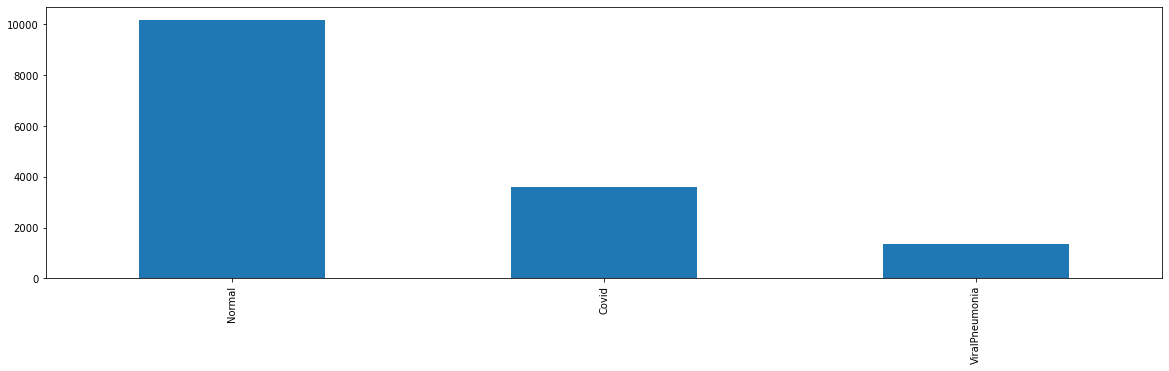

In [11]:
df_radiography['class'].value_counts().plot(kind='bar')

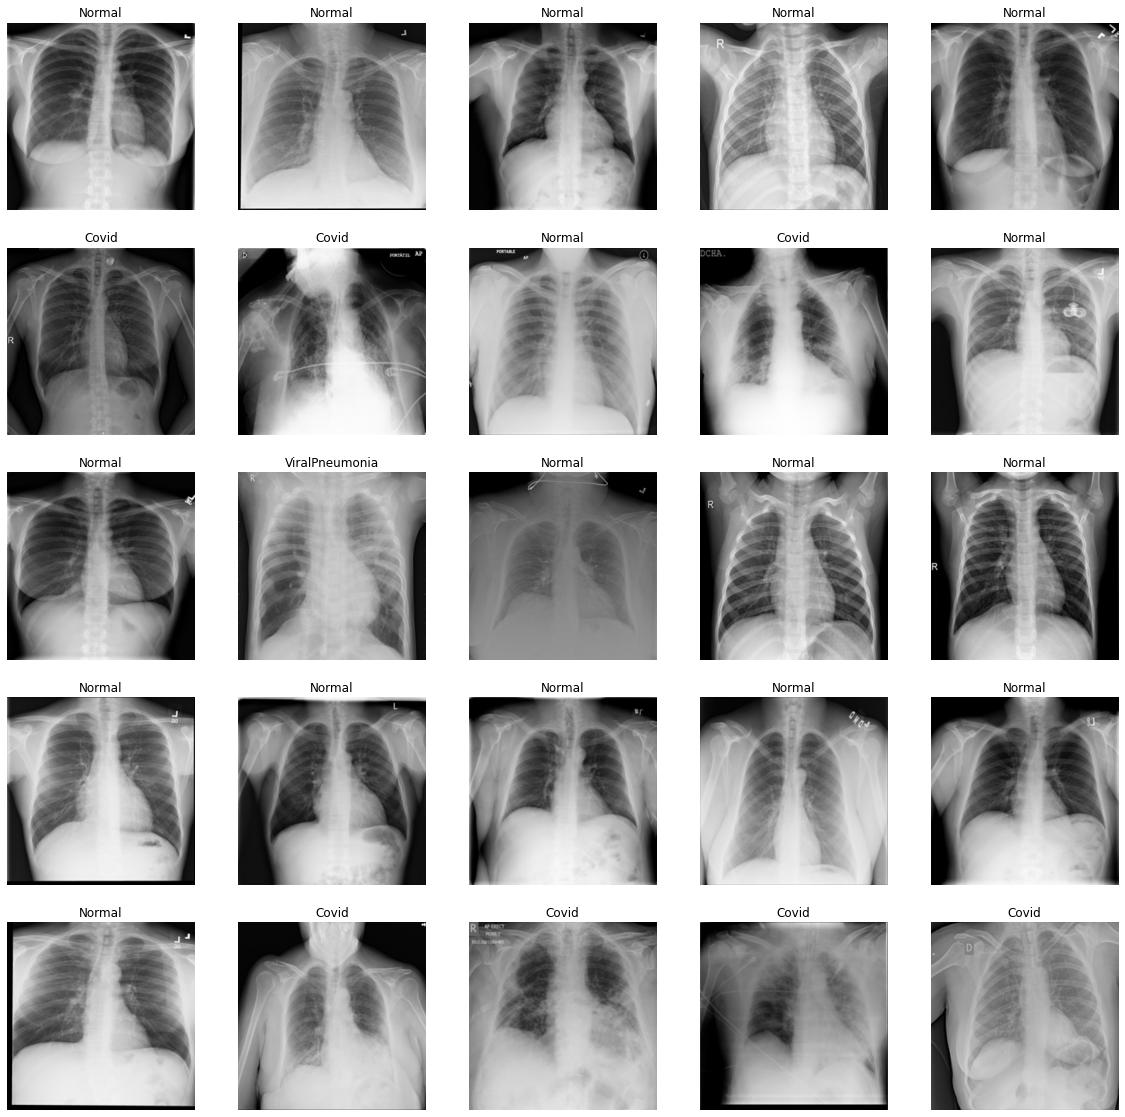

In [12]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,3000,25))): 
    
    imagem=cv2.imread(df_radiography['path'][i])
    plt.subplot(5,5,n+1)
    plt.imshow(cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB))
    plt.title(df_radiography['class'][i])
    plt.axis('off')     
plt.show()

#### Preparando dataset

In [22]:
class radiographyDataset(Dataset):
    
    def __init__(self, dataframe, transform=None):

        self.img_dir = dataframe['path']
        y = dataframe['class']
        le = LabelEncoder()
        self.y = le.fit_transform(y)
        #self.y = classe
        self.transform = transform
         
    # obtem uma linha do dataset
    def __getitem__(self, idx):
        img = Image.open(self.img_dir[idx])
        #Estava dando erro na normalizacao, por isso converti aqui para cinza
        img = ImageOps.grayscale(img)
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[idx]
        return img, label
           
    def __len__(self):
        return len(self.y)
    

#### Transforms e data loader

In [23]:
batch_size = 16
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize([64, 64]),
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(64, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        #transforms.Normalize([0.5, 0.5, 0.5],
                             #[0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize([64, 64]),
        transforms.ToTensor(),
        #transforms.Normalize([0.5, 0.5, 0.5],
                             #[0.5, 0.5, 0.5])
    ]),
}

data_train,data_test = train_test_split(df_radiography,test_size=0.20,random_state=42)
data_train,data_test = data_train.reset_index(),data_test.reset_index()

image_datasets = {'train': radiographyDataset(data_train,data_transforms['train']),
                  'val': radiographyDataset(data_test,data_transforms['val'])}


dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#device = torch.device('cpu')

In [24]:
dataset_sizes

{'train': 12122, 'val': 3031}

<AxesSubplot:>

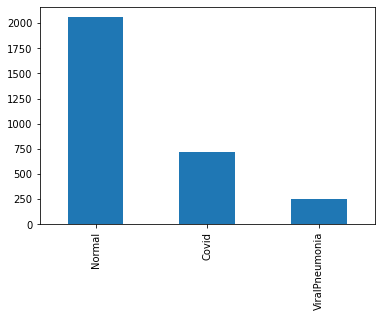

In [25]:
data_test['class'].value_counts().plot(kind='bar')

#### Modelo

In [13]:
class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(8, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        #self.drop_out = nn.Dropout()
        # 64x6x8 (widht, height, out_channels) /2 (MaxPool2d) = 16384 /2 (MaxPool2d) = 8192
        self.fc1 = nn.Linear(8192, 64)
        self.fc2 = nn.Linear(64, num_classes)


    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = torch.flatten(out, 1)
        #out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        #out = F.log_softmax(out, dim = 1)
        return out   

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    #print(outputs.shape, labels.shape)
                    _, preds = torch.max(outputs, 1)
                    
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} -> Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())   
        print('-' * 10)
    time_elapsed = time.time() - since
    print('Treino completo em {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Melhor valor de acurácia: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

#### Treinando o modelo

In [32]:
num_classes = 3
num_epochs = 20
learning_rate = 0.005

model = ConvNet(num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [33]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs)

Epoch 0/19
----------
train -> Loss: 0.5899 Acc: 0.7395
val -> Loss: 0.4474 Acc: 0.8047
Epoch 1/19
----------
train -> Loss: 0.4598 Acc: 0.7983
val -> Loss: 0.4021 Acc: 0.8301
Epoch 2/19
----------
train -> Loss: 0.4212 Acc: 0.8188
val -> Loss: 0.3905 Acc: 0.8430
Epoch 3/19
----------
train -> Loss: 0.4004 Acc: 0.8300
val -> Loss: 0.3594 Acc: 0.8522
Epoch 4/19
----------
train -> Loss: 0.3721 Acc: 0.8404
val -> Loss: 0.3681 Acc: 0.8515
Epoch 5/19
----------
train -> Loss: 0.3611 Acc: 0.8493
val -> Loss: 0.3417 Acc: 0.8538
Epoch 6/19
----------
train -> Loss: 0.3500 Acc: 0.8528
val -> Loss: 0.3346 Acc: 0.8581
Epoch 7/19
----------
train -> Loss: 0.3031 Acc: 0.8713
val -> Loss: 0.2895 Acc: 0.8792
Epoch 8/19
----------
train -> Loss: 0.2918 Acc: 0.8762
val -> Loss: 0.2794 Acc: 0.8825
Epoch 9/19
----------
train -> Loss: 0.2814 Acc: 0.8815
val -> Loss: 0.2742 Acc: 0.8829
Epoch 10/19
----------
train -> Loss: 0.2790 Acc: 0.8851
val -> Loss: 0.2698 Acc: 0.8835
Epoch 11/19
----------
train ->

In [34]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in dataloaders['val']:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = model(x_batch)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())
y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

- 0 = Covid
- 1 = Normal
- 2 = ViralPneumonia

In [35]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.71      0.84      0.77        38
           1       0.95      0.91      0.93       139
           2       0.92      0.92      0.92        13

    accuracy                           0.89       190
   macro avg       0.86      0.89      0.87       190
weighted avg       0.90      0.89      0.90       190



In [36]:
cm =  confusion_matrix(y_true_list, y_pred_list)
cm

array([[ 32,   6,   0],
       [ 12, 126,   1],
       [  1,   0,  12]])

In [ ]:
#torch.save(model.state_dict(), "output/rad_classifier.pt") 

### Teste com balanceamento das classes

In [37]:
y_train = []
with torch.no_grad():
    for x_batch, y_batch in dataloaders['train']:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_train.append(y_batch.cpu().numpy())
y_train = np.array([item for sublist in y_train for item in sublist])

In [38]:
y_train

array([1, 1, 2, ..., 1, 1, 0])

In [39]:
class_weights=class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
class_weights=torch.tensor(class_weights,dtype=torch.float)

/home/tiago/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1 2], y=[1 1 2 ... 1 1 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [40]:
num_classes = 3
num_epochs = 20
learning_rate = 0.005

model2 = ConvNet(num_classes)
model2 = model2.to(device)

criterion2 = nn.CrossEntropyLoss(weight=class_weights)
optimizer2 = torch.optim.SGD(model2.parameters(), lr=learning_rate, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler2 = lr_scheduler.StepLR(optimizer2, step_size=7, gamma=0.1)

In [41]:
model2 = train_model(model2, criterion2, optimizer2, exp_lr_scheduler2, num_epochs)

Epoch 0/19
----------
train -> Loss: 0.6593 Acc: 0.6666
val -> Loss: 0.5990 Acc: 0.7816
Epoch 1/19
----------
train -> Loss: 0.5192 Acc: 0.7258
val -> Loss: 0.4467 Acc: 0.8103
Epoch 2/19
----------
train -> Loss: 0.4569 Acc: 0.7533
val -> Loss: 0.4184 Acc: 0.8225
Epoch 3/19
----------
train -> Loss: 0.4307 Acc: 0.7688
val -> Loss: 0.3784 Acc: 0.8360
Epoch 4/19
----------
train -> Loss: 0.4107 Acc: 0.7842
val -> Loss: 0.3751 Acc: 0.8373
Epoch 5/19
----------
train -> Loss: 0.3937 Acc: 0.7924
val -> Loss: 0.3563 Acc: 0.8215
Epoch 6/19
----------
train -> Loss: 0.3837 Acc: 0.7943
val -> Loss: 0.3763 Acc: 0.8337
Epoch 7/19
----------
train -> Loss: 0.3316 Acc: 0.8244
val -> Loss: 0.3014 Acc: 0.8591
Epoch 8/19
----------
train -> Loss: 0.3138 Acc: 0.8286
val -> Loss: 0.2938 Acc: 0.8568
Epoch 9/19
----------
train -> Loss: 0.3111 Acc: 0.8337
val -> Loss: 0.2869 Acc: 0.8598
Epoch 10/19
----------
train -> Loss: 0.3052 Acc: 0.8378
val -> Loss: 0.2829 Acc: 0.8651
Epoch 11/19
----------
train ->

### Image Enhancement

In [107]:
df_radiography['class'][11]

'Covid'

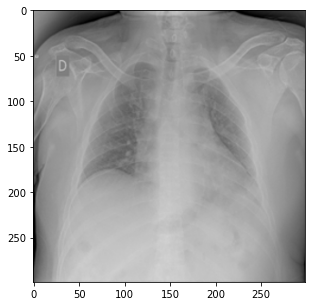

In [108]:
gray_image = cv2.cvtColor(cv2.imread(df_radiography['path'][11]), cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)) 

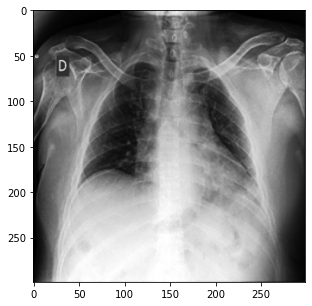

In [109]:
# Equalizing the contrast of a given grayscale image
gray_img_eqhist=cv2.equalizeHist(gray_image)
plt.imshow(cv2.cvtColor(gray_img_eqhist, cv2.COLOR_GRAY2RGB)) 

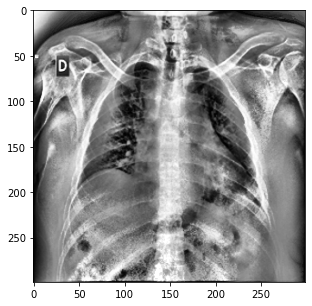

In [110]:
# Contrast Limited Adaptive Histogram Equalization
clahe=cv2.createCLAHE(clipLimit=40)
gray_img_clahe=clahe.apply(gray_img_eqhist)
plt.imshow(cv2.cvtColor(gray_img_clahe, cv2.COLOR_GRAY2RGB)) 

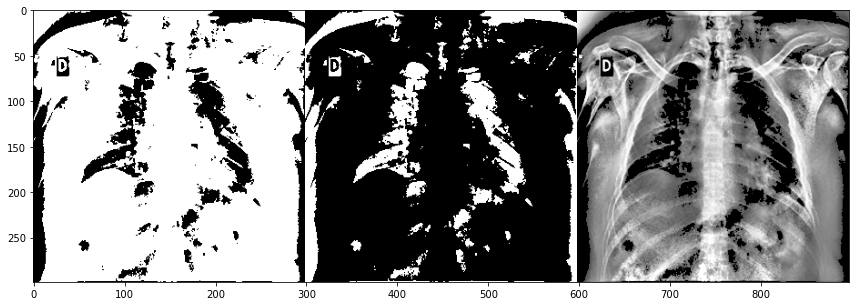

In [118]:
th=80
max_val=255
ret, o1 = cv2.threshold(gray_img_clahe, th, max_val, cv2.THRESH_BINARY)
ret, o2 = cv2.threshold(gray_img_clahe, th, max_val, cv2.THRESH_BINARY_INV)
ret, o3 = cv2.threshold(gray_img_clahe, th, max_val, cv2.THRESH_TOZERO)

final=np.concatenate((o1,o2,o3),axis=1)
plt.imshow(cv2.cvtColor(final, cv2.COLOR_GRAY2RGB)) 

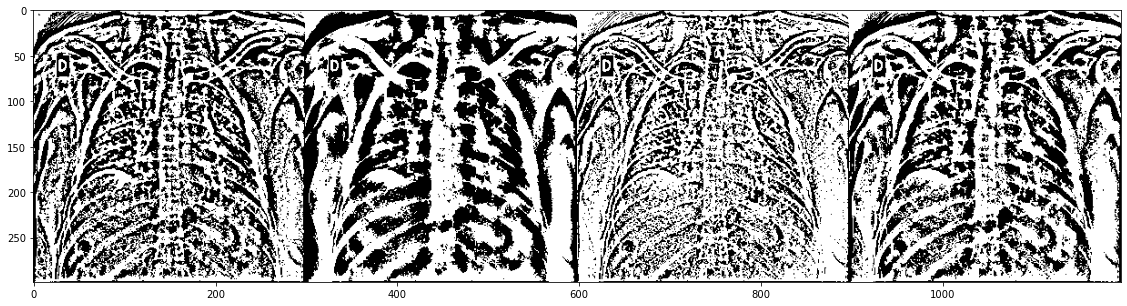

In [206]:
thresh1 = cv2.adaptiveThreshold(gray_img_clahe, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
thresh2 = cv2.adaptiveThreshold(gray_img_clahe, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 31, 3)
thresh3 = cv2.adaptiveThreshold(gray_img_clahe, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 13, 5)
thresh4 = cv2.adaptiveThreshold(gray_img_clahe, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 4)
final=np.concatenate((thresh1,thresh2,thresh3,thresh4),axis=1)
plt.imshow(cv2.cvtColor(final, cv2.COLOR_GRAY2RGB)) 

In [15]:
class radiographyDataset_Enhancement(Dataset):
    
    def __init__(self, dataframe, transform=None):

        self.img_dir = dataframe['path']
        y = dataframe['class']
        le = LabelEncoder()
        self.y = le.fit_transform(y)
        #self.y = classe
        self.transform = transform
         
    # obtem uma linha do dataset
    def __getitem__(self, idx):
        img = cv2.cvtColor(cv2.imread(self.img_dir[idx]), cv2.COLOR_BGR2GRAY)
        # Equalizing the contrast of a given grayscale image
        img = cv2.equalizeHist(img)
        # CLAHE Contrast Limited Adaptive Histogram Equalization
        clahe=cv2.createCLAHE(clipLimit=40)
        img=clahe.apply(img)
        #th=80
        #max_val=255
        # Threshold THRESH_TOZERO
        #ret, img = cv2.threshold(img, th, max_val, cv2.THRESH_TOZERO)
        # AdaptiveThreshold
        img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 13, 5)
        #img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 4)
        
        img = Image.fromarray(img)
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[idx]
        return img, label
           
    def __len__(self):
        return len(self.y)
    

In [16]:
batch_size = 16
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize([64, 64]),
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(64, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        #transforms.Normalize([0.5, 0.5, 0.5],
                             #[0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize([64, 64]),
        transforms.ToTensor(),
        #transforms.Normalize([0.5, 0.5, 0.5],
                             #[0.5, 0.5, 0.5])
    ]),
}

data_train,data_test = train_test_split(df_radiography,test_size=0.20,random_state=42)
data_train,data_test = data_train.reset_index(),data_test.reset_index()

image_datasets = {'train': radiographyDataset_Enhancement(data_train,data_transforms['train']),
                  'val': radiographyDataset_Enhancement(data_test,data_transforms['val'])}


dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#device = torch.device('cpu')

In [215]:
num_classes = 3
num_epochs = 20
learning_rate = 0.005

model3 = ConvNet(num_classes)
model3 = model3.to(device)

criterion3 = nn.CrossEntropyLoss()
optimizer3 = torch.optim.SGD(model3.parameters(), lr=learning_rate, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler3 = lr_scheduler.StepLR(optimizer3, step_size=7, gamma=0.1)

In [216]:
model3 = train_model(model3, criterion3, optimizer3, exp_lr_scheduler3, num_epochs)

Epoch 0/19
train -> Loss: 0.7318 Acc: 0.6882
val -> Loss: 0.5543 Acc: 0.7476
----------
Epoch 1/19
train -> Loss: 0.5069 Acc: 0.7778
val -> Loss: 0.3644 Acc: 0.8466
----------
Epoch 2/19
train -> Loss: 0.4150 Acc: 0.8232
val -> Loss: 0.3222 Acc: 0.8677
----------
Epoch 3/19
train -> Loss: 0.3767 Acc: 0.8448
val -> Loss: 0.2731 Acc: 0.8918
----------
Epoch 4/19
train -> Loss: 0.3385 Acc: 0.8605
val -> Loss: 0.2718 Acc: 0.8990
----------
Epoch 5/19
train -> Loss: 0.3289 Acc: 0.8631
val -> Loss: 0.2414 Acc: 0.9103
----------
Epoch 6/19
train -> Loss: 0.3094 Acc: 0.8749
val -> Loss: 0.2471 Acc: 0.9063
----------
Epoch 7/19
train -> Loss: 0.2565 Acc: 0.8978
val -> Loss: 0.2288 Acc: 0.9182
----------
Epoch 8/19
train -> Loss: 0.2449 Acc: 0.9003
val -> Loss: 0.2157 Acc: 0.9208
----------
Epoch 9/19
train -> Loss: 0.2404 Acc: 0.9064
val -> Loss: 0.2107 Acc: 0.9241
----------
Epoch 10/19
train -> Loss: 0.2385 Acc: 0.9064
val -> Loss: 0.2065 Acc: 0.9244
----------
Epoch 11/19
train -> Loss: 0.22

In [217]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in dataloaders['val']:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = model3(x_batch)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())
y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

print(classification_report(y_true_list, y_pred_list))


              precision    recall  f1-score   support

           0       0.88      0.95      0.91        38
           1       0.98      0.96      0.97       139
           2       0.85      0.85      0.85        13

    accuracy                           0.95       190
   macro avg       0.90      0.92      0.91       190
weighted avg       0.95      0.95      0.95       190



In [219]:
cm =  confusion_matrix(y_true_list, y_pred_list)
cm

array([[ 36,   1,   1],
       [  5, 133,   1],
       [  0,   2,  11]])

In [229]:
torch.save(model3.state_dict(), "output/rad_classifier.pt") 

## Resultados

### Sem pre processamento

<img src="output/radiography_normal.png">


``` 

                precision    recall  f1-score   support

           0       0.71      0.84      0.77        38
           1       0.95      0.91      0.93       139
           2       0.92      0.92      0.92        13

    accuracy                           0.89       190
   macro avg       0.86      0.89      0.87       190
weighted avg       0.90      0.89      0.90       190

array([[ 32,   6,   0],
       [ 12, 126,   1],
       [  1,   0,  12]])

``` 

### CLAHE Contrast Limited Adaptive Histogram Equalization

```
clahe=cv2.createCLAHE(clipLimit=40)
gray_img_clahe=clahe.apply(gray_img_eqhist)
```

<img src="output/radiography_clahe.png">

``` 
                precision    recall  f1-score   support

           0       0.74      0.74      0.74        38
           1       0.93      0.94      0.93       139
           2       0.83      0.77      0.80        13

    accuracy                           0.88       190
   macro avg       0.83      0.81      0.82       190
weighted avg       0.88      0.88      0.88       190

array([[ 28,   9,   1],
       [  8, 130,   1],
       [  2,   1,  10]])

``` 

### THRESH_TOZERO

```
ret, img = cv2.threshold(img, th, max_val, cv2.THRESH_TOZERO)
``` 

<img src="output/radiography_thresh2zero.png">

``` 
                precision    recall  f1-score   support

           0       0.83      0.79      0.81        38
           1       0.94      0.96      0.95       139
           2       0.92      0.85      0.88        13

    accuracy                           0.92       190
   macro avg       0.90      0.86      0.88       190
weighted avg       0.91      0.92      0.91       190

array([[ 30,   8,   0],
       [  5, 133,   1],
       [  1,   1,  11]])
```


### ADAPTIVE_THRESH_GAUSSIAN 13, 5

```
cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 13, 5)
``` 

<img src="output/radiography_adaptativethresh13-5.png">

``` 

                precision    recall  f1-score   support

           0       0.88      0.95      0.91        38
           1       0.98      0.96      0.97       139
           2       0.85      0.85      0.85        13

    accuracy                           0.95       190
   macro avg       0.90      0.92      0.91       190
weighted avg       0.95      0.95      0.95       190


array([[ 36,   1,   1],
       [  5, 133,   1],
       [  0,   2,  11]])

``` 


### ADAPTIVE_THRESH_GAUSSIAN 31, 4

```
cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 4)
``` 

<img src="output/radiography_adaptativethresh31-4.png">

``` 

                precision    recall  f1-score   support

           0       0.94      0.79      0.86        38
           1       0.94      0.98      0.96       139
           2       0.86      0.92      0.89        13

    accuracy                           0.94       190
   macro avg       0.91      0.90      0.90       190
weighted avg       0.94      0.94      0.94       190

array([[ 30,   7,   1],
       [  2, 136,   1],
       [  0,   1,  12]])

``` 


In [17]:
model = ConvNet(3)
model.load_state_dict(torch.load("output/rad_classifier.pt"))
model.eval()

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(8, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=8192, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
)

In [18]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in dataloaders['val']:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = model(x_batch)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())
y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

print(classification_report(y_true_list, y_pred_list))


              precision    recall  f1-score   support

           0       0.98      0.86      0.92        51
           1       0.94      0.99      0.96       121
           2       1.00      0.94      0.97        18

    accuracy                           0.95       190
   macro avg       0.97      0.93      0.95       190
weighted avg       0.95      0.95      0.95       190



In [19]:
cm =  confusion_matrix(y_true_list, y_pred_list)
cm

array([[ 44,   7,   0],
       [  1, 120,   0],
       [  0,   1,  17]])